In [2]:
#import required libraries
import requests 
import pandas as pd 
import numpy as np 
import random 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Folium installed
Libraries imported.


In [11]:
#setting foursquare API variables
CLIENT_ID='ZGTQVDILRFZ5LSHVPZPZ2L3V2ZUGLJKFCT0OGUNO0LKSOWF5'
CLIENT_SECRET='TJVT3BWA0W2GVRNOCY5LBB5JZ24JCKNK2AIE3YFCBU4UALB2'
VERSION='20200308'

In [4]:
#Get new york data --> get the boroughs, neighbourhoods, latitude and longitude to be used for the Foursquare API URI
ny_url='https://cocl.us/new_york_dataset'
resp=requests.get(ny_url).json()
   # all data is present in features label
features=resp['features']
    
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
new_york_data = pd.DataFrame(columns=column_names)
    
for data in features:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
new_york_data.shape

(306, 4)

In [6]:
#Number of neighbourhoods per borough
num_neigh=new_york_data.groupby('Borough')['Neighborhood'].count()
num_neigh

Borough
Bronx            52
Brooklyn         70
Manhattan        40
Queens           81
Staten Island    63
Name: Neighborhood, dtype: int64

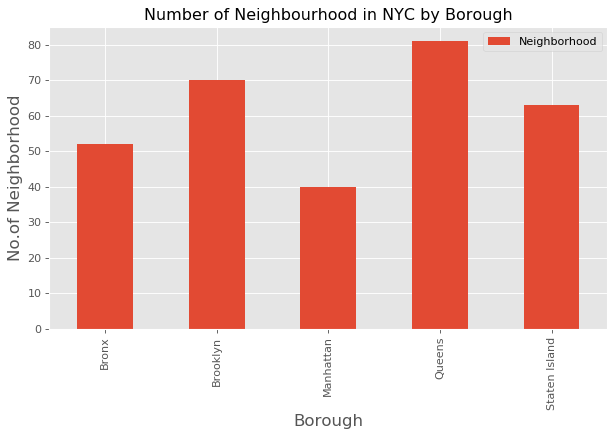

In [8]:
#plot neighbourhoods 
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
num_neigh.plot(kind='bar')
#legend
plt.legend()
plt.show()

In [12]:
#Function to get venues by passing the lonigtude and latitude of each neighbourhood
def get_venues(lat,lng):
    
    #set variables
    radius=1000  #1000 metre radius of the latitude
    LIMIT=100

    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [14]:
# prepare neighborhood list that contains indian restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)

In [15]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Parkchester,55dfa36a498e164ef19bef7b,Premium Sweets & Restaurant
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird


In [16]:
indian_rest_ny.shape

(153, 4)

In [17]:
indian_rest_ny_new=pd.DataFrame.copy(indian_rest_ny, deep = True)

In [18]:
#Number of neighbourhoods per borough
num_indian_res=indian_rest_ny_new.groupby('Borough')['Name'].count()
num_indian_res

Borough
Bronx             8
Brooklyn         22
Manhattan        41
Queens           73
Staten Island     9
Name: Name, dtype: int64

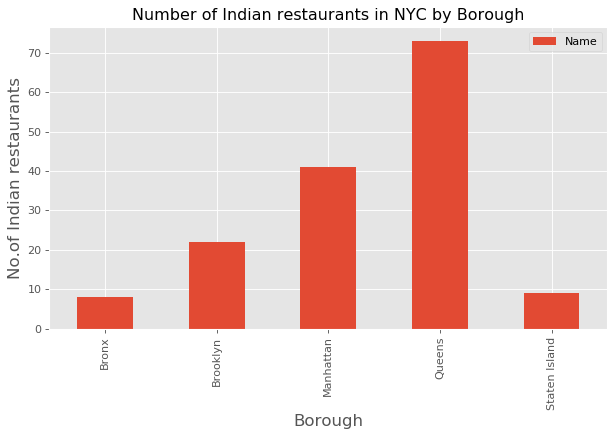

In [23]:
#plot neighbourhoods 
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Indian restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian restaurants', fontsize=15)
#giving a bar plot
num_indian_res.plot(kind='bar')
#legend
plt.legend()
plt.show()

In [20]:
indian_rest_ny_new.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Parkchester,55dfa36a498e164ef19bef7b,Premium Sweets & Restaurant
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird


In [21]:
#get venue details
def get_venue_details(venue_id):

    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [22]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)

In [24]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,8.0,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Parkchester,0,0,0,0.0,0
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3


In [25]:
indian_rest_stats_new =indian_rest_stats_ny[indian_rest_stats_ny.ID !=0 ]

In [26]:
indian_rest_stats_new.shape

(48, 7)

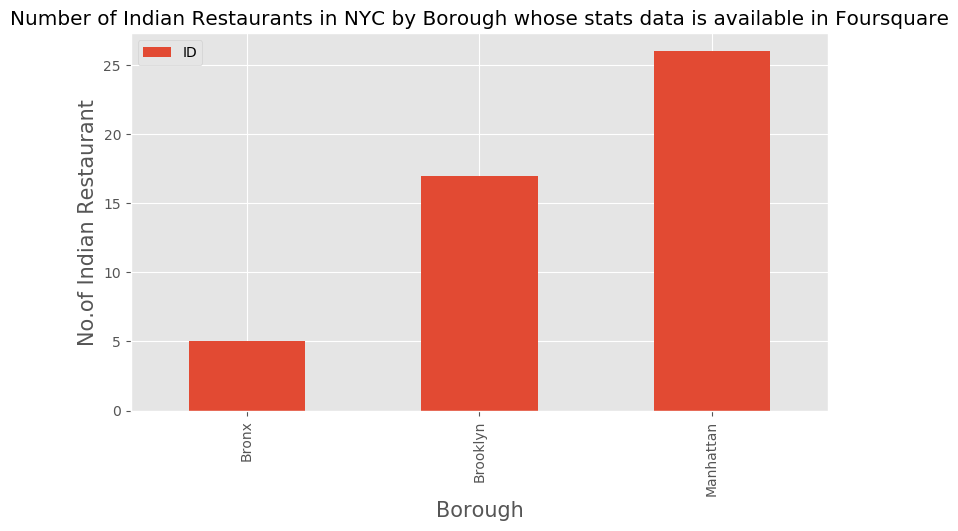

In [27]:
#plot indian restaurants whose stats are available in Foursquare
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants in NYC by Borough whose stats data is available in Foursquare')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurant', fontsize=15)
#giving a bar plot
indian_rest_stats_new.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [28]:
indian_res_rating_8 =indian_rest_stats_new[indian_rest_stats_new['Rating']>8.0]

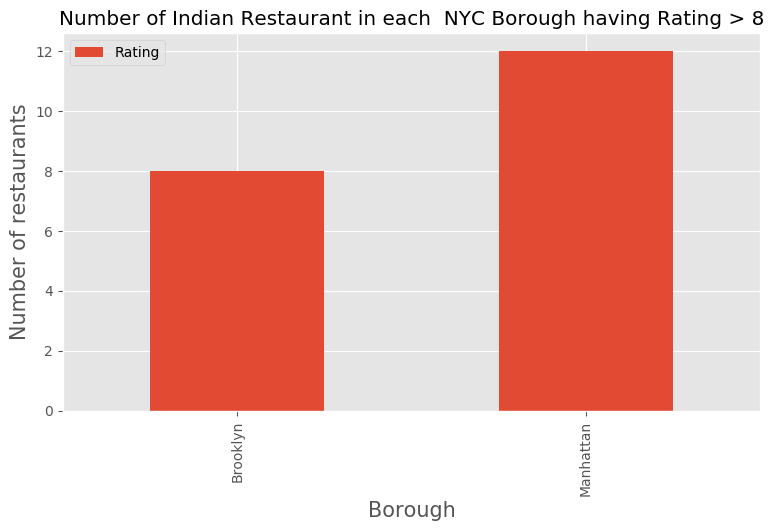

In [29]:
#Plotting number of restaurnts per Borough having a Rating > 8
plt.figure(figsize=(9,5), dpi = 100)
# title. 
plt.title('Number of Indian Restaurant in each  NYC Borough having Rating > 8')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of restaurants', fontsize=15)
#giving a bar plot
indian_res_rating_8.groupby('Borough')['Rating'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [30]:
indian_res_top_10 =indian_res_rating_8.sort_values(by=['Likes','Tips'], ascending=False).head(10)

In [31]:
indian_res_top_10

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
40,Manhattan,Tribeca,4bbb9dbded7776b0e1ad3e51,Tamarind TriBeCa,590,9.1,148
49,Manhattan,Gramercy,4a70a75bf964a52016d81fe3,Bhatti Indian Grill,421,8.7,160
32,Manhattan,Yorkville,5272ca4511d22488f6895caf,Drunken Munkey,208,8.5,61
33,Manhattan,Roosevelt Island,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux,186,8.4,83
42,Manhattan,West Village,591794df2be42556988e4a8e,Rahi,115,8.7,24
38,Manhattan,Chelsea,4b4aab62f964a520978c26e3,Dil-e Punjab Deli,108,8.7,44
35,Manhattan,Upper West Side,42489a80f964a5208b201fe3,Swagat,106,8.4,39
22,Brooklyn,North Side,5631511b498e3d6d7e0a4df0,Tikka Indian Grill,95,8.5,29
23,Brooklyn,South Side,5631511b498e3d6d7e0a4df0,Tikka Indian Grill,95,8.5,29
16,Brooklyn,Prospect Lefferts Gardens,4bb93b70cf2fc9b6fe64a002,Gandhi Fine Indian Cuisine,81,8.6,47


In [32]:
ny_neighborhood_stats =pd.merge(indian_res_rating_8,new_york_data, on='Neighborhood')

In [33]:
ny_neighborhood_stats.rename(columns={"Borough_x" : "Borough"}, inplace=True)

In [34]:
ny_neighborhood_stats.drop(columns='Borough_y', inplace=True)

In [35]:
ny_neighborhood_stats.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips,Latitude,Longitude
0,Brooklyn,Bay Ridge,4b5a4dc8f964a520a2bb28e3,Taj Mahal,38,8.3,26,40.625801,-74.030621
1,Brooklyn,East Flatbush,512a9ea9e4b004fb8eeb84e5,Silver Krust,12,8.1,3,40.641718,-73.936103
2,Brooklyn,Fort Greene,57596dad498e732300496b23,Dosa Royale,75,8.7,22,40.688527,-73.972906
3,Brooklyn,Clinton Hill,57596dad498e732300496b23,Dosa Royale,75,8.7,22,40.693229,-73.967843
4,Brooklyn,Prospect Lefferts Gardens,4bb93b70cf2fc9b6fe64a002,Gandhi Fine Indian Cuisine,81,8.6,47,40.658420,-73.954899


In [36]:
# create map and display it
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
markers = folium.map.FeatureGroup()

# loop through to  add each to the marker feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    markers.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+','+ny_neighborhood_stats['Name']+'('+ny_neighborhood_stats['Rating'].map(str)+')'


for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add to map
ny_map.add_child(markers)